# Bag of Words

## Imports

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import math
from dotenv import load_dotenv
import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
IS_PAPERSPACE = os.getcwd().startswith('/notebooks')
dir_env = os.path.join(os.getcwd(), '.env') if IS_PAPERSPACE else os.path.join(os.getcwd(), '..', '.env')
_ = load_dotenv(dotenv_path=dir_env)

In [3]:
wandb.login(key=os.getenv('WANDB_KEY'))
wandb._disable_jupyter = True

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dario-wigger (nlp-lantsch-schmassmann-wigger). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\dario\_netrc


## Data

In [4]:
df_traindata = pd.read_csv("data/train.csv") if IS_PAPERSPACE else pd.read_csv("../data/train.csv")

train_texts, validation_texts, train_labels, validation_labels = train_test_split(
    df_traindata['text'].tolist(), 
    df_traindata['sentiment'].tolist(), 
    test_size=0.2, 
    random_state=42
)

df_testdata = pd.read_csv("data/test.csv") if IS_PAPERSPACE else pd.read_csv("../data/test.csv")
test_texts = df_testdata['text'].tolist()
test_labels = df_testdata['sentiment'].tolist()

## Vectorization
Creation of a Bag-of-Words Matrix

In [5]:
countVectorizer = CountVectorizer(stop_words='english', max_features=10000)
tfidfVectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

## Baseline

### Training
Training a Naive Bayes Classifier

In [6]:
model = make_pipeline(countVectorizer, MultinomialNB())

In [7]:
model.fit(train_texts, train_labels)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=10000, stop_words='english')),
                ('multinomialnb', MultinomialNB())])

### Evaluation on Validation Set

In [8]:
val_preds = model.predict(validation_texts)

print("Validation Accuracy:", accuracy_score(validation_labels, val_preds))
print(classification_report(validation_labels, val_preds))

Validation Accuracy: 0.7616322675629879
              precision    recall  f1-score   support

           0       0.72      0.71      0.71     15109
           1       0.79      0.80      0.80     20890

    accuracy                           0.76     35999
   macro avg       0.76      0.75      0.75     35999
weighted avg       0.76      0.76      0.76     35999



### Evaluation on Test Set

In [13]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
    report = classification_report(y, y_pred, output_dict=True)

    wandb.init(project="nlp-lantsch-schmassmann-wigger", entity="nlp-lantsch-schmassmann-wigger")
    wandb.log({
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "classification_report": report,
    })
    wandb.finish()

    return precision, recall, f1

In [ ]:
evaluate_model(model, test_texts, test_labels)

f1,▁
precision,▁
recall,▁
f1,0.75989
precision,0.75963
recall,0.76031


## Classifier Comparison
Comparison of different classifiers

In [ ]:
def evaluateClassifier(classifier, classifier_name, vectorizer, vectorizer_name):
    model = make_pipeline(vectorizer, classifier)
    model.fit(train_texts, train_labels)
    
    val_preds = model.predict(validation_texts)
    val_acc = accuracy_score(validation_labels, val_preds)
    val_report = classification_report(validation_labels, val_preds, output_dict=True)
    val_conf_matrix = confusion_matrix(validation_labels, val_preds)

    test_preds = model.predict(test_texts)
    test_acc = accuracy_score(test_labels, test_preds)
    test_report = classification_report(test_labels, test_preds, output_dict=True)
    test_conf_matrix = confusion_matrix(test_labels, test_preds)

    result = {
        'classifier': classifier_name,
        'vectorizer': vectorizer_name,
        'val_accuracy': val_acc,
        'val_precision': val_report['1']['precision'],
        'val_recall': val_report['1']['recall'],
        'val_f1': val_report['1']['f1-score'],
        'test_accuracy': test_acc,
        'test_precision': test_report['1']['precision'],
        'test_recall': test_report['1']['recall'],
        'test_f1': test_report['1']['f1-score'],
    }

    results_name = f"executions/bagOfWords/{classifier_name}_{vectorizer_name}"
    result_df = pd.DataFrame([result])
    result_df.to_csv(f"{results_name}.csv", index=False)

    with open(f"{results_name}_val_confusion.json", 'w') as f:
        json.dump(val_conf_matrix.tolist(), f, indent=4)
    with open(f"{results_name}_test_confusion.json", 'w') as f:
        json.dump(test_conf_matrix.tolist(), f, indent=4)

    print(f"\nClassifier: {classifier_name} | Vectorizer: {vectorizer_name}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    
    evaluate_model(model, test_texts, test_labels)

### Naive Bayes

In [14]:
evaluateClassifier(classifier=MultinomialNB(), classifier_name="MultinomialNB", vectorizer=countVectorizer, vectorizer_name="CountVectorizer")


Classifier: MultinomialNB | Vectorizer: CountVectorizer
Validation Accuracy: 0.7616
Test Accuracy: 0.7603


f1,▁
precision,▁
recall,▁
f1,0.75989
precision,0.75963
recall,0.76031


In [15]:
evaluateClassifier(classifier=MultinomialNB(), classifier_name="MultinomialNB", vectorizer=tfidfVectorizer, vectorizer_name="TfidfVectorizer")


Classifier: MultinomialNB | Vectorizer: TfidfVectorizer
Validation Accuracy: 0.7574
Test Accuracy: 0.7577


f1,▁
precision,▁
recall,▁
f1,0.75333
precision,0.75768
recall,0.75768


### Logistic Regression

In [16]:
evaluateClassifier(classifier=LogisticRegression(max_iter=1000), classifier_name="LogisticRegression", vectorizer=countVectorizer, vectorizer_name="CountVectorizer")


Classifier: LogisticRegression | Vectorizer: CountVectorizer
Validation Accuracy: 0.7669
Test Accuracy: 0.7654


f1,▁
precision,▁
recall,▁
f1,0.76258
precision,0.76446
recall,0.76539


In [17]:
evaluateClassifier(classifier=LogisticRegression(max_iter=1000), classifier_name="LogisticRegression", vectorizer=tfidfVectorizer, vectorizer_name="TfidfVectorizer")


Classifier: LogisticRegression | Vectorizer: TfidfVectorizer
Validation Accuracy: 0.7697
Test Accuracy: 0.7683


f1,▁
precision,▁
recall,▁
f1,0.76559
precision,0.76738
recall,0.76828


### Linear SVM

In [18]:
evaluateClassifier(classifier=LinearSVC(), classifier_name="LinearSVC", vectorizer=countVectorizer, vectorizer_name="CountVectorizer")

C:\Users\dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Classifier: LinearSVC | Vectorizer: CountVectorizer
Validation Accuracy: 0.7607
Test Accuracy: 0.7609


f1,▁
precision,▁
recall,▁
f1,0.75807
precision,0.75974
recall,0.76086


In [19]:
evaluateClassifier(classifier=LinearSVC(), classifier_name="LinearSVC", vectorizer=tfidfVectorizer, vectorizer_name="TfidfVectorizer")

C:\Users\dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Classifier: LinearSVC | Vectorizer: TfidfVectorizer
Validation Accuracy: 0.7609
Test Accuracy: 0.7633


f1,▁
precision,▁
recall,▁
f1,0.76105
precision,0.76199
recall,0.76328


### XGBoost

In [20]:
evaluateClassifier(classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), classifier_name="XGBoost", vectorizer=countVectorizer, vectorizer_name="CountVectorizer")

C:\Users\dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:13:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classifier: XGBoost | Vectorizer: CountVectorizer
Validation Accuracy: 0.7395
Test Accuracy: 0.7361


f1,▁
precision,▁
recall,▁
f1,0.72499
precision,0.74296
recall,0.73608


In [21]:
evaluateClassifier(classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), classifier_name="XGBoost", vectorizer=tfidfVectorizer, vectorizer_name="TfidfVectorizer")

C:\Users\dario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:13:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classifier: XGBoost | Vectorizer: TfidfVectorizer
Validation Accuracy: 0.7372
Test Accuracy: 0.7354


f1,▁
precision,▁
recall,▁
f1,0.72413
precision,0.74237
recall,0.73537


## Results Analysis

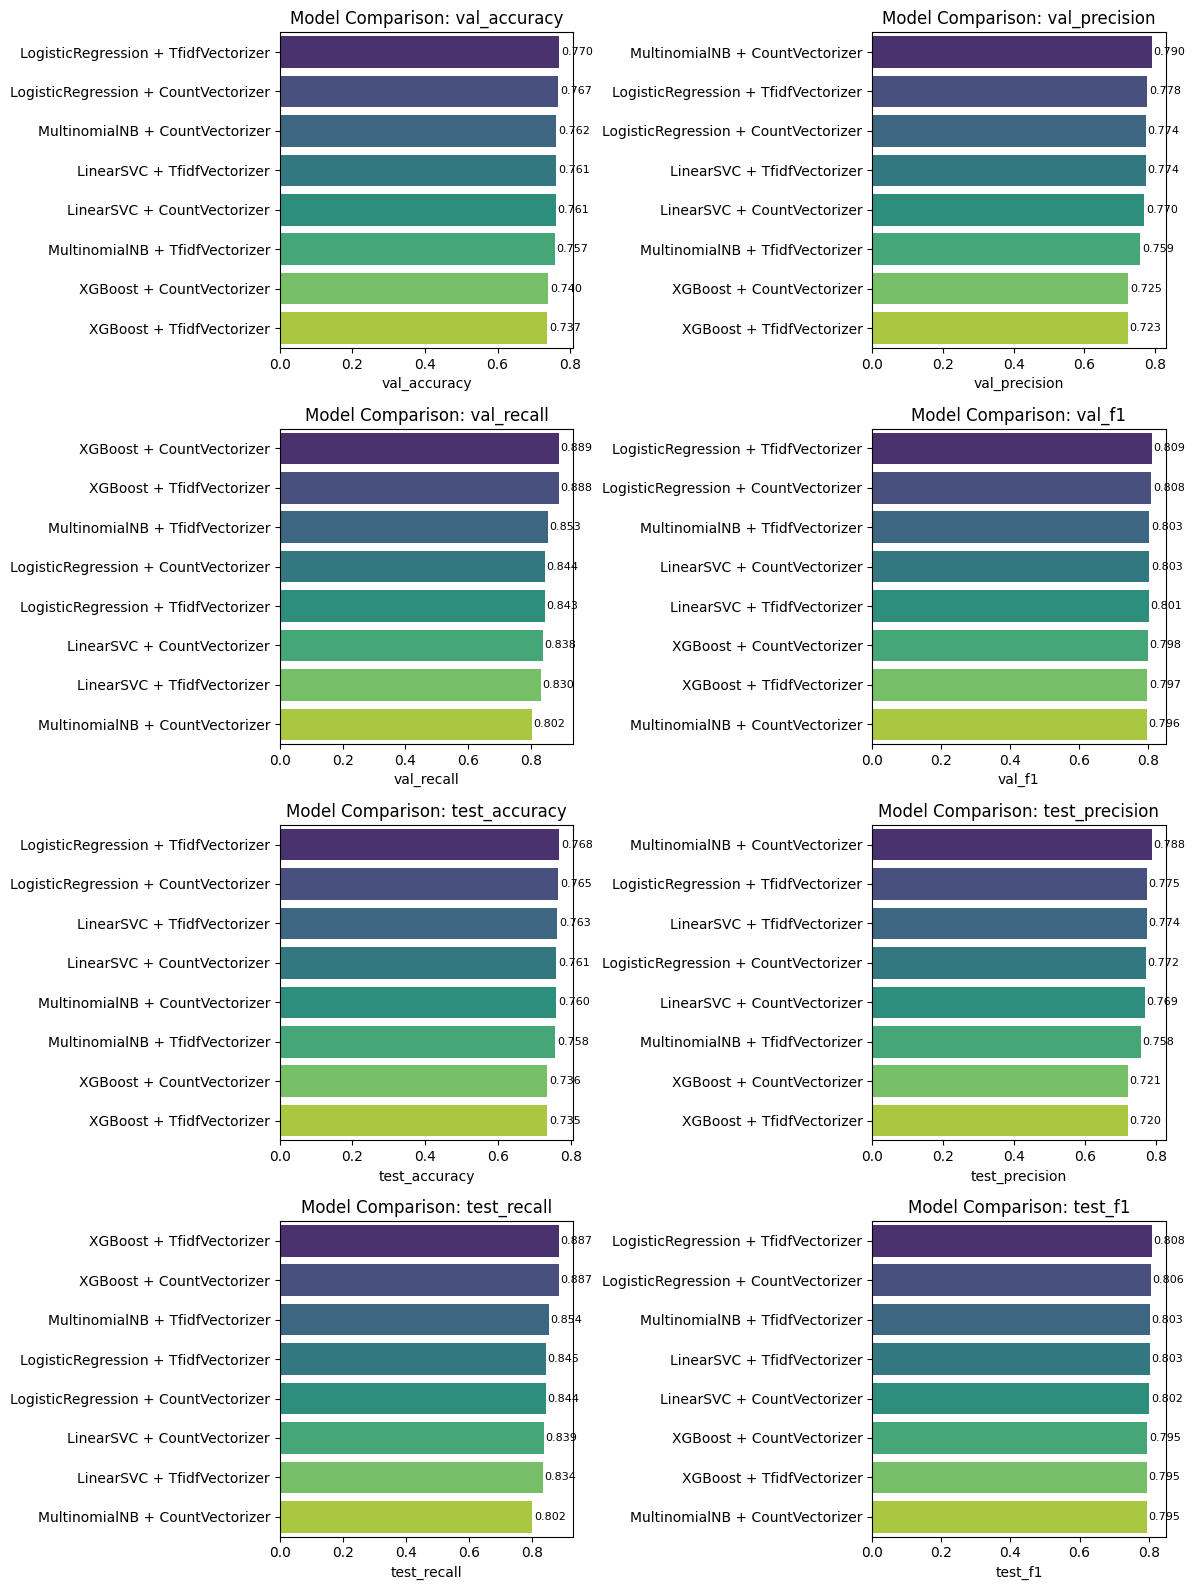

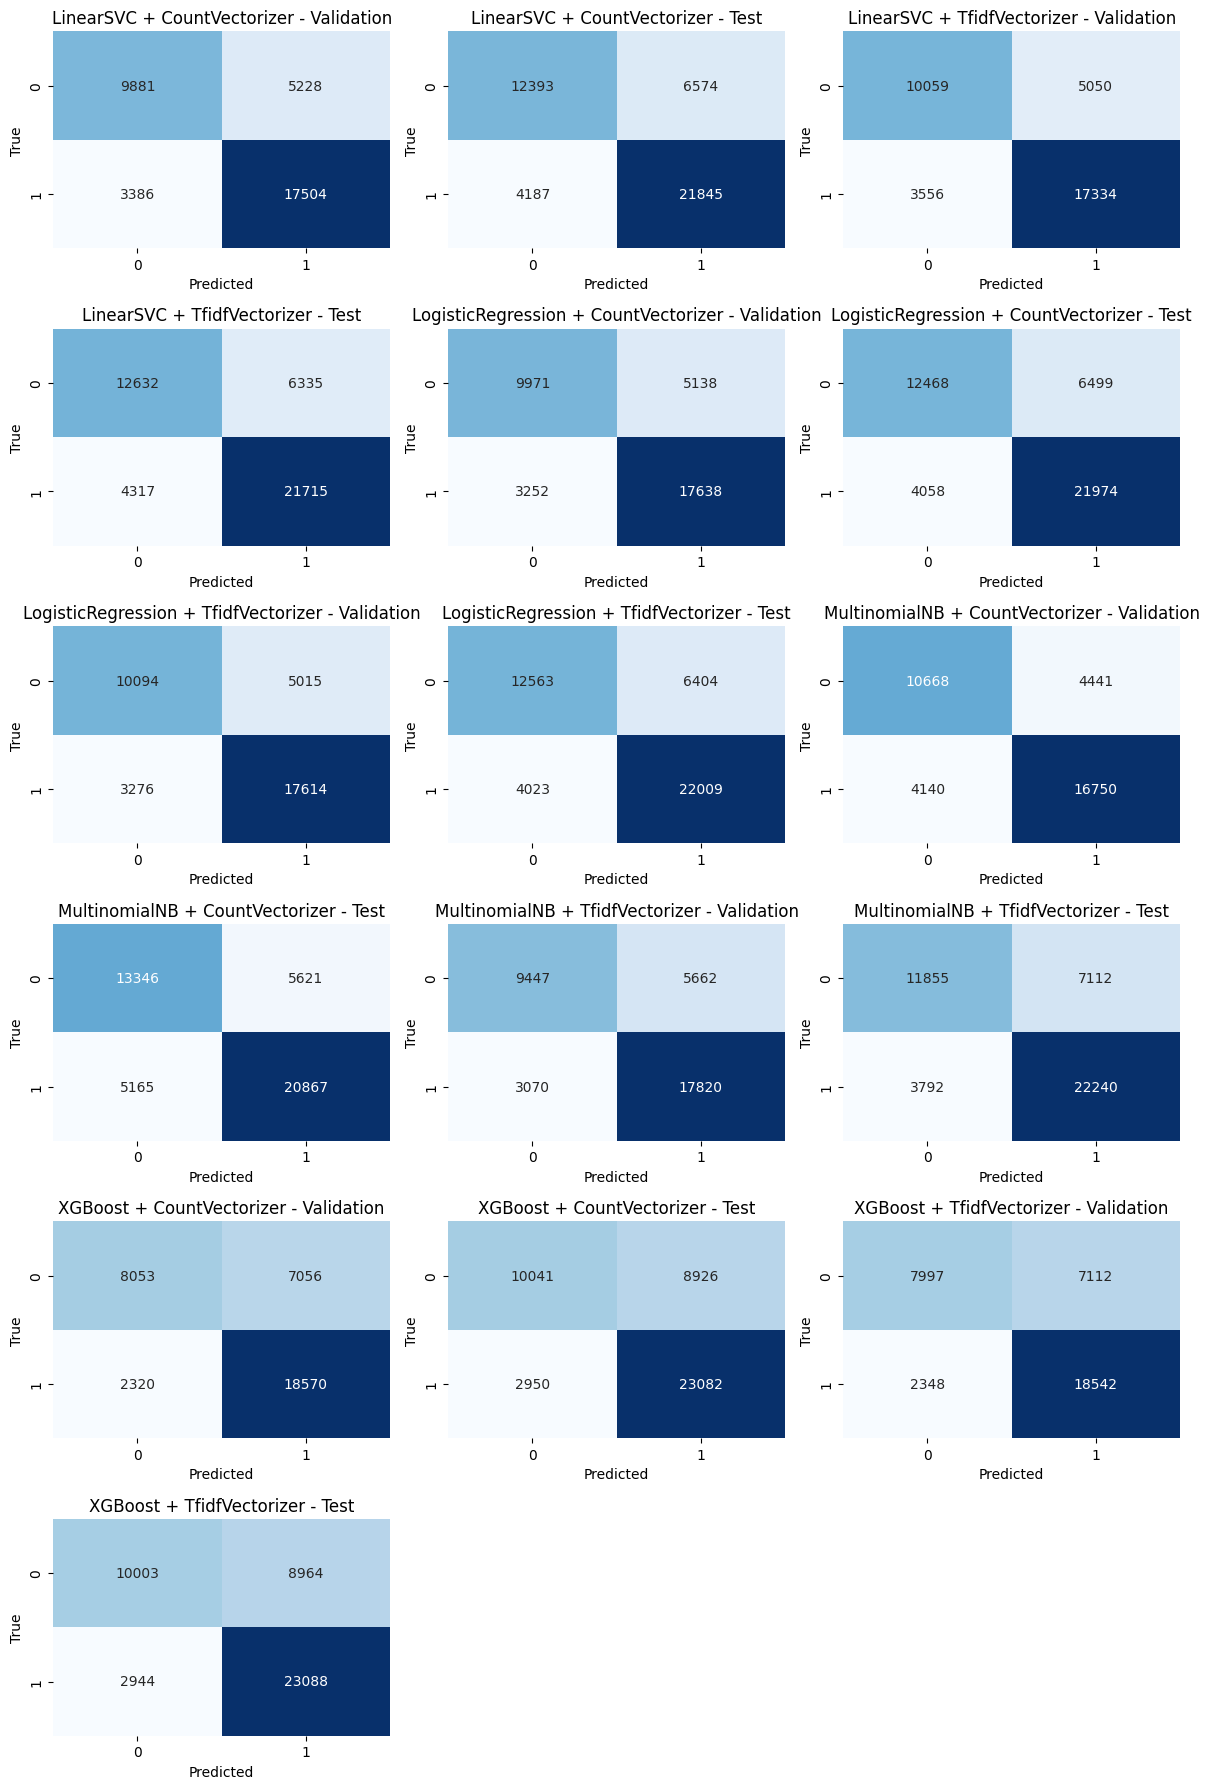

,classifier,vectorizer,val_accuracy,val_precision,val_recall,val_f1,test_accuracy,test_precision,test_recall,test_f1,Classifier,Vectorizer,Validation Confusion,Test Confusion,Model
0,LinearSVC,CountVectorizer,0.760716,0.770016,0.837913,0.802531,0.760861,0.768676,0.839159,0.802373,LinearSVC,CountVectorizer,"[[9881, 5228], [3386, 17504]]","[[12393, 6574], [4187, 21845]]",LinearSVC + CountVectorizer
1,LinearSVC,TfidfVectorizer,0.760938,0.774392,0.829775,0.801128,0.763284,0.774153,0.834166,0.803040,LinearSVC,TfidfVectorizer,"[[10059, 5050], [3556, 17334]]","[[12632, 6335], [4317, 21715]]",LinearSVC + TfidfVectorizer
2,LogisticRegression,CountVectorizer,0.766938,0.774412,0.844327,0.807860,0.765395,0.771749,0.844115,0.806311,LogisticRegression,CountVectorizer,"[[9971, 5138], [3252, 17638]]","[[12468, 6499], [4058, 21974]]",LogisticRegression + CountVectorizer
3,LogisticRegression,TfidfVectorizer,0.769688,0.778382,0.843179,0.809486,0.768284,0.774610,0.845459,0.808486,LogisticRegression,TfidfVectorizer,"[[10094, 5015], [3276, 17614]]","[[12563, 6404], [4023, 22009]]",LogisticRegression + TfidfVectorizer
4,MultinomialNB,CountVectorizer,0.761632,0.790430,0.801819,0.796084,0.760306,0.787791,0.801590,0.794631,MultinomialNB,CountVectorizer,"[[10668, 4441], [4140, 16750]]","[[13346, 5621], [5165, 20867]]",MultinomialNB + CountVectorizer
5,MultinomialNB,TfidfVectorizer,0.757438,0.758879,0.853040,0.803209,0.757684,0.757700,0.854333,0.803120,MultinomialNB,TfidfVectorizer,"[[9447, 5662], [3070, 17820]]","[[11855, 7112], [3792, 22240]]",MultinomialNB + TfidfVectorizer
6,XGBoost,CountVectorizer,0.739548,0.724655,0.888942,0.798435,0.736083,0.721132,0.886678,0.795382,XGBoost,CountVectorizer,"[[8053, 7056], [2320, 18570]]","[[10041, 8926], [2950, 23082]]",XGBoost + CountVectorizer
7,XGBoost,TfidfVectorizer,0.737215,0.722772,0.887602,0.796751,0.735372,0.720329,0.886908,0.794987,XGBoost,TfidfVectorizer,"[[7997, 7112], [2348, 18542]]","[[10003, 8964], [2944, 23088]]",XGBoost + TfidfVectorizer


In [22]:
def analyze_all_results(results_dir):
    result_records = []

    csv_files = glob.glob(os.path.join(results_dir, "*.csv"))

    for csv_file in csv_files:
        base_name = os.path.splitext(os.path.basename(csv_file))[0]

        # Parse classifier and vectorizer from filename
        if "_" not in base_name:
            continue  # skip malformed files

        classifier, vectorizer = base_name.split("_", 1)

        # Read metrics
        try:
            df = pd.read_csv(csv_file)
            record = df.iloc[0].to_dict()
        except Exception as e:
            print(f"Failed to read {csv_file}: {e}")
            continue

        record["Classifier"] = classifier
        record["Vectorizer"] = vectorizer

        # Read confusion matrices
        try:
            with open(os.path.join(results_dir, f"{base_name}_val_confusion.json")) as f:
                record["Validation Confusion"] = json.load(f)
            with open(os.path.join(results_dir, f"{base_name}_test_confusion.json")) as f:
                record["Test Confusion"] = json.load(f)
        except Exception as e:
            print(f"Failed to load confusion matrix for {base_name}: {e}")

        result_records.append(record)

    all_results = pd.DataFrame(result_records)
    all_results["Model"] = all_results["Classifier"] + " + " + all_results["Vectorizer"]

    # === Plot Metrics ===
    metrics = [
        "val_accuracy", "val_precision", "val_recall", "val_f1",
        "test_accuracy", "test_precision", "test_recall", "test_f1"
    ]

    # Filter valid metrics that exist in your DataFrame
    valid_metrics = [m for m in metrics if m in all_results.columns]
    num_metrics = len(valid_metrics)
    cols = 2
    rows = math.ceil(num_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for idx, metric in enumerate(valid_metrics):
        ax = axes[idx]
        df_sorted = all_results.sort_values(metric, ascending=False)

        sns.barplot(x=metric, y="Model", data=df_sorted, palette="viridis", ax=ax)
        ax.set_title(f"Model Comparison: {metric}")
        ax.set_xlabel(metric)
        ax.set_ylabel("")

        # Add value labels
        for bar in ax.patches:
            width = bar.get_width()
            ax.text(
                width + 0.005, bar.get_y() + bar.get_height() / 2,
                f"{width:.3f}", va="center", fontsize=8
            )

    # Hide unused subplots
    for i in range(len(valid_metrics), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    # === Plot Confusion Matrices (optional) ===
    models_with_matrices = [r for r in result_records if "Validation Confusion" in r and "Test Confusion" in r]
    num_models = len(models_with_matrices)
    cols = 3  # 3 matrices per row
    rows = math.ceil(num_models * 2 / cols)  # 2 matrices (val + test) per model

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    i = 0
    for row in models_with_matrices:
        for phase in ["Validation", "Test"]:
            matrix = row[f"{phase} Confusion"]
            model_name = f"{row['Classifier']} + {row['Vectorizer']}"
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
            ax.set_title(f"{model_name} - {phase}")
            ax.set_xlabel("Predicted")
            ax.set_ylabel("True")
            i += 1

    # Hide unused subplots
    for j in range(i, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return all_results

analyze_all_results(results_dir="executions/bagOfWords")